In [1]:
import sys
sys.path.append('../reconstruct_missing_data')

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    create_missing_mask, 
    split_and_scale_data, 
    eof_weights, 
    get_land_silhouette,
)

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
from pathlib import Path
from json import dump, load
import os

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
## Load CESM and FOCI data, including ALL features and mask for Ocean values:

# Specify path to data: Test data of full data.
# data_path='../data/test_data/'
data_path='climate_index_collection/data/raw/2022-08-22/'

# Load data:
data_CESM = load_data_set(data_path=data_path, data_source_name='CESM')
data_FOCI = load_data_set(data_path=data_path, data_source_name='FOCI')

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [4]:
## Extract raw data for single feature:

# Specify feature to select:
feature = 'sea-surface-temperature'

# Extract feature:
feature_raw_CESM = data_CESM[feature]
feature_raw_FOCI = data_FOCI[feature]

In [8]:
# For equidistant latitude/longitude grids the area weights are proportional to cos(lat).
# Before applying Singular Value Decomposition, input data is multiplied with the square root of the weights.
feature_weighted_CESM = feature_raw_CESM * eof_weights(feature_raw_CESM)
feature_weighted_FOCI = feature_raw_FOCI * eof_weights(feature_raw_FOCI)

In [9]:
# Remove seasonal cycle to get anomalies, use whole time span as climatology:
climatology_CESM = feature_weighted_CESM.groupby("time.month").mean("time")
climatology_FOCI = feature_weighted_FOCI.groupby("time.month").mean("time")
feature_anomaly_CESM = (feature_weighted_CESM.groupby("time.month") - climatology_CESM).drop("month")
feature_anomaly_FOCI = (feature_weighted_FOCI.groupby("time.month") - climatology_FOCI).drop("month")

In [12]:
## Split feature anomaly into Northern and Southern hemisphere:

# Define masks:
mask_CESM_NH = feature_anomaly_CESM.coords["lat"] >= 0
mask_CESM_SH = feature_anomaly_CESM.coords["lat"] <= 0

# Apply masks:
feature_anomaly_CESM_NH = feature_anomaly_CESM.where(mask_CESM_NH)
feature_anomaly_CESM_SH = feature_anomaly_CESM.where(mask_CESM_SH)

In [13]:
# Flatten spatial dimensions:
feature_anomaly_flat_CESM = feature_anomaly_CESM.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")
feature_anomaly_flat_CESM_NH = feature_anomaly_CESM_NH.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")
feature_anomaly_flat_CESM_SH = feature_anomaly_CESM_SH.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

feature_anomaly_flat_FOCI = feature_anomaly_FOCI.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

In [86]:
# For mean rel. loss reduction maps, we used the first and last 120 training samples, which is samples 0..119 and 9469..9588.
# Extract these samples, then perform SVD on only extracted subset of samples, for comparison.
feature_anomaly_flat_CESM_extract = xr.concat([feature_anomaly_flat_CESM[0:120],feature_anomaly_flat_CESM[9469:9589]], dim="time")

In [87]:
## Perform SVD on flat feature anomaly, after removing mean over time:

# CESM: Whole world
pc_CESM, s_CESM, eof_CESM = sp.linalg.svd(
    feature_anomaly_flat_CESM_extract - feature_anomaly_flat_CESM_extract.mean(axis=0), full_matrices=False
)

print("pc shape: ", pc_CESM.shape)
print("s shape: ", s_CESM.shape)
print("eof shape: ", eof_CESM.shape)

pc shape:  (240, 240)
s shape:  (240,)
eof shape:  (240, 8276)


In [19]:
# ## Perform SVD on flat feature anomaly, after removing mean over time:

# # CESM: Northern hemisphere
# pc_CESM_NH, s_CESM_NH, eof_CESM_NH = sp.linalg.svd(
#     feature_anomaly_flat_CESM_NH - feature_anomaly_flat_CESM_NH.mean(axis=0), full_matrices=False
# )

# print("pc shape: ", pc_CESM_NH.shape)
# print("s shape: ", s_CESM_NH.shape)
# print("eof shape: ", eof_CESM_NH.shape)

pc shape:  (11988, 6912)
s shape:  (6912,)
eof shape:  (6912, 6912)


In [20]:
# ## Perform SVD on flat feature anomaly, after removing mean over time:

# # CESM: Southern hemisphere
# pc_CESM_SH, s_CESM_SH, eof_CESM_SH = sp.linalg.svd(
#     feature_anomaly_flat_CESM_SH - feature_anomaly_flat_CESM_SH.mean(axis=0), full_matrices=False
# )

# print("pc shape: ", pc_CESM_SH.shape)
# print("s shape: ", s_CESM_SH.shape)
# print("eof shape: ", eof_CESM_SH.shape)

pc shape:  (11988, 6912)
s shape:  (6912,)
eof shape:  (6912, 6912)


In [88]:
# For mean rel. loss reduction maps, we used the first and last 120 training samples, which is samples 0..119 and 9479..9598.
# Extract these samples, then perform SVD on only extracted subset of samples, for comparison.
feature_anomaly_flat_FOCI_extract = xr.concat([feature_anomaly_flat_FOCI[0:120],feature_anomaly_flat_FOCI[9479:9599]], dim="time")

In [89]:
## Perform SVD on extract of flat feature anomaly samples, after removing mean over time:

# FOCI: Whole world
pc_FOCI, s_FOCI, eof_FOCI = sp.linalg.svd(
    feature_anomaly_flat_FOCI_extract - feature_anomaly_flat_FOCI_extract.mean(axis=0), full_matrices=False
)

print("pc shape: ", pc_FOCI.shape)
print("s shape: ", s_FOCI.shape)
print("eof shape: ", eof_FOCI.shape)

pc shape:  (240, 240)
s shape:  (240,)
eof shape:  (240, 12949)


In [10]:
## Store / reload complete FOCI EOF results for whole world:

# Set path:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_EOF')

# # Store as np.array:
# np.save(path / "pc_FOCI.npy", pc_FOCI)
# np.save(path / "s_FOCI.npy", s_FOCI)
# np.save(path / "eof_FOCI.npy", eof_FOCI)

# Reload:
pc_FOCI = np.load(path / "pc_FOCI.npy")
s_FOCI = np.load(path / "s_FOCI.npy")
eof_FOCI = np.load(path / "eof_FOCI.npy")

In [90]:
# Compute explained variance from singular values:
exp_var_CESM = s_CESM**2 / (s_CESM**2).sum()
# exp_var_CESM_NH = s_CESM_NH**2 / (s_CESM_NH**2).sum()
# exp_var_CESM_SH = s_CESM_SH**2 / (s_CESM_SH**2).sum()
exp_var_FOCI = s_FOCI**2 / (s_FOCI**2).sum()

## Get accumulated explained variance:

# Initialize storage:
exp_var_acc_CESM = np.zeros(exp_var_CESM.shape)
# exp_var_acc_CESM_NH = np.zeros(exp_var_CESM_NH.shape)
# exp_var_acc_CESM_SH = np.zeros(exp_var_CESM_SH.shape)
exp_var_acc_FOCI = np.zeros(exp_var_FOCI.shape)

# # Run over array of explained variance:
for i in range(len(exp_var_CESM)):
    
    # First step to initialize accumulated variance:
    if i == 0:
        exp_var_acc_CESM[i] = exp_var_CESM[i]
    else:
        exp_var_acc_CESM[i] = exp_var_acc_CESM[i-1] + exp_var_CESM[i]

# # Run over array of explained variance:
# for i in range(len(exp_var_CESM_NH)):
    
#     # First step to initialize accumulated variance:
#     if i == 0:
#         exp_var_acc_CESM_NH[i] = exp_var_CESM_NH[i]
#     else:
#         exp_var_acc_CESM_NH[i] = exp_var_acc_CESM_NH[i-1] + exp_var_CESM_NH[i]
        
# # Run over array of explained variance:
# for i in range(len(exp_var_CESM_SH)):
    
#     # First step to initialize accumulated variance:
#     if i == 0:
#         exp_var_acc_CESM_SH[i] = exp_var_CESM_SH[i]
#     else:
#         exp_var_acc_CESM_SH[i] = exp_var_acc_CESM_SH[i-1] + exp_var_CESM_SH[i]
        
# Run over array of explained variance:
for i in range(len(exp_var_FOCI)):
    
    # First step to initialize accumulated variance:
    if i == 0:
        exp_var_acc_FOCI[i] = exp_var_FOCI[i]
    else:
        exp_var_acc_FOCI[i] = exp_var_acc_FOCI[i-1] + exp_var_FOCI[i]

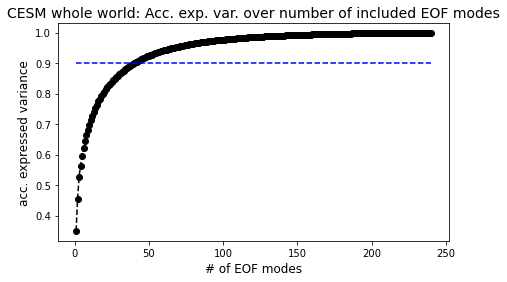

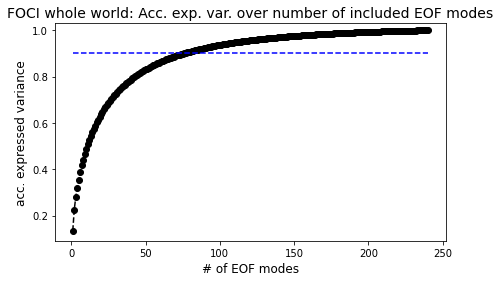

In [91]:
## Plot accumulated expressed variance over EOF modes.

# CESM: Whole world
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,len(exp_var_acc_CESM),step=1)+1, exp_var_acc_CESM, color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,len(exp_var_acc_CESM),step=1)+1, np.ones(len(exp_var_acc_CESM))*0.9, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('CESM whole world: Acc. exp. var. over number of included EOF modes', fontsize=14)
axes.set_xlabel('# of EOF modes', fontsize=12)
axes.set_ylabel('acc. expressed variance', fontsize=12)
#axes.legend()
plt.show() 

# # CESM: Northern hemisphere
# fig, axes = plt.subplots(1,1,figsize=(7,4))

# axes.plot(np.arange(0,len(exp_var_acc_CESM_NH),step=1)+1, exp_var_acc_CESM_NH, color='black', marker='o', linestyle='--')
# # Optionally add threshold:
# axes.plot(np.arange(0,len(exp_var_acc_CESM_NH),step=1)+1, np.ones(len(exp_var_acc_CESM_NH))*0.9, color='blue', linestyle='--')

# axes.set_ylim(top=1.03)
# axes.set_title('CESM NH: Acc. exp. var. over number of included EOF modes', fontsize=14)
# axes.set_xlabel('# of EOF modes', fontsize=12)
# axes.set_ylabel('acc. expressed variance', fontsize=12)
# #axes.legend()
# plt.show() 

# # CESM: Southern hemisphere
# fig, axes = plt.subplots(1,1,figsize=(7,4))

# axes.plot(np.arange(0,len(exp_var_acc_CESM_SH),step=1)+1, exp_var_acc_CESM_SH, color='black', marker='o', linestyle='--')
# # Optionally add threshold:
# axes.plot(np.arange(0,len(exp_var_acc_CESM_SH),step=1)+1, np.ones(len(exp_var_acc_CESM_SH))*0.9, color='blue', linestyle='--')

# axes.set_ylim(top=1.03)
# axes.set_title('CESM SH: Acc. exp. var. over number of included EOF modes', fontsize=14)
# axes.set_xlabel('# of EOF modes', fontsize=12)
# axes.set_ylabel('acc. expressed variance', fontsize=12)
# #axes.legend()
# plt.show() 

# FOCI: Whole world
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,len(exp_var_acc_FOCI),step=1)+1, exp_var_acc_FOCI, color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,len(exp_var_acc_FOCI),step=1)+1, np.ones(len(exp_var_acc_FOCI))*0.9, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('FOCI whole world: Acc. exp. var. over number of included EOF modes', fontsize=14)
axes.set_xlabel('# of EOF modes', fontsize=12)
axes.set_ylabel('acc. expressed variance', fontsize=12)
#axes.legend()
plt.show() 

In [92]:
# ## Look for how many EOFs we need to include, to exceed 90% of total explained variance:
print("CESM whole world:\n",exp_var_acc_CESM[:50],"\n")
# print("CESM NH world:\n",exp_var_acc_CESM_NH[:50],"\n")
# print("CESM SH world:\n",exp_var_acc_CESM_SH[:50])

CESM whole world:
 [0.34987725 0.45399552 0.52723154 0.56351695 0.59562652 0.62275922
 0.64310638 0.66253333 0.68084003 0.69692091 0.71264472 0.72735436
 0.74062037 0.75259922 0.76365402 0.77399546 0.78292843 0.79106785
 0.7989477  0.80664232 0.81378619 0.82041019 0.8265648  0.83270377
 0.83851734 0.84392614 0.8492214  0.8541331  0.85883646 0.86324304
 0.86748637 0.87156607 0.87536914 0.87913546 0.88279511 0.88628772
 0.88961032 0.8928967  0.89604682 0.89903669 0.901903   0.90469553
 0.9074047  0.90998806 0.91250462 0.91489884 0.9171937  0.91943455
 0.92156689 0.92368566] 



In [93]:
print("FOCI whole world:\n",exp_var_acc_FOCI[:50],"\n")

FOCI whole world:
 [0.1343884  0.22584067 0.27985791 0.31802808 0.35490624 0.38778141
 0.41783787 0.4421511  0.46574338 0.48833614 0.50884252 0.52651718
 0.54339691 0.55965456 0.57485351 0.58864154 0.60202822 0.61429752
 0.62578909 0.63679304 0.64770544 0.6582968  0.668184   0.6775662
 0.68645855 0.69511857 0.70348403 0.7116249  0.71921988 0.72661507
 0.7336564  0.74051562 0.74728293 0.7537476  0.75987735 0.76572305
 0.77140662 0.77683386 0.78206992 0.78716851 0.79209272 0.79694631
 0.80173336 0.80638682 0.81076452 0.81497742 0.81909295 0.82307179
 0.82696098 0.83080586] 



In [94]:
## Postprocess pc time series: Divide by its standard deviation.

# CESM whole world:
pc_std_CESM = pc_CESM.std(axis=0)
pc_CESM /= pc_std_CESM

# Put to xarray, define 'mode' index:
mode_CESM = np.arange(1, len(pc_std_CESM) + 1)
pc_CESM = pc_CESM.T
pc_CESM = xr.DataArray(
    pc_CESM,
    dims=('mode', 'time'),
    coords={'mode': mode_CESM, 'time': feature_anomaly_flat_CESM_extract['time']}
)

# # CESM Northern hemisphere:
# pc_std_CESM_NH = pc_CESM_NH.std(axis=0)
# pc_CESM_NH /= pc_std_CESM_NH

# # Put to xarray, define 'mode' index:
# mode_CESM_NH = np.arange(1, len(pc_std_CESM_NH) + 1)
# pc_CESM_NH = pc_CESM_NH.T
# pc_CESM_NH = xr.DataArray(
#     pc_CESM_NH,
#     dims=('mode', 'time'),
#     coords={'mode': mode_CESM_NH, 'time': feature_anomaly_flat_CESM_NH['time']}
# )

# # CESM Southern hemisphere:
# pc_std_CESM_SH = pc_CESM_SH .std(axis=0)
# pc_CESM_SH /= pc_std_CESM_SH 

# # Put to xarray, define 'mode' index:
# mode_CESM_SH = np.arange(1, len(pc_std_CESM_SH) + 1)
# pc_CESM_SH = pc_CESM_SH.T
# pc_CESM_SH = xr.DataArray(
#     pc_CESM_SH,
#     dims=('mode', 'time'),
#     coords={'mode': mode_CESM_SH, 'time': feature_anomaly_flat_CESM_SH['time']}
# )

# FOCI whole world:
pc_std_FOCI = pc_FOCI.std(axis=0)
pc_FOCI /= pc_std_FOCI

# Put to xarray, define 'mode' index:
mode_FOCI = np.arange(1, len(pc_std_FOCI) + 1)
pc_FOCI = pc_FOCI.T
pc_FOCI = xr.DataArray(
    pc_FOCI,
    dims=('mode', 'time'),
    coords={'mode': mode_FOCI, 'time': feature_anomaly_flat_FOCI_extract['time']}
)

In [95]:
## Postprocess eofs:

# CESM whole world:
eof_CESM *= pc_std_CESM[:, np.newaxis]
eof_CESM *= s_CESM[:, np.newaxis]
eofs_CESM = feature_anomaly_flat_CESM_extract.copy()
eofs_CESM[:, eofs_CESM[0].notnull().values] = eof_CESM
eofs_CESM = eofs_CESM.unstack(dim='tmp_space').rename(**{'time': 'mode'})
eofs_CESM.coords['mode'] = mode_CESM

# # CESM Northern hemisphere:
# eof_CESM_NH *= pc_std_CESM_NH[:, np.newaxis]
# eof_CESM_NH *= s_CESM_NH[:, np.newaxis]
# eofs_CESM_NH = feature_anomaly_flat_CESM_NH.copy()[:mode_CESM_NH.shape[0]]
# eofs_CESM_NH[:, eofs_CESM_NH[0].notnull().values] = eof_CESM_NH
# eofs_CESM_NH = eofs_CESM_NH.unstack(dim='tmp_space').rename(**{'time': 'mode'})
# eofs_CESM_NH.coords['mode'] = mode_CESM_NH

# # CESM Northern hemisphere:
# eof_CESM_SH *= pc_std_CESM_SH[:, np.newaxis]
# eof_CESM_SH *= s_CESM_SH[:, np.newaxis]
# eofs_CESM_SH = feature_anomaly_flat_CESM_SH.copy()[:mode_CESM_SH.shape[0]]
# eofs_CESM_SH[:, eofs_CESM_SH[0].notnull().values] = eof_CESM_SH
# eofs_CESM_SH = eofs_CESM_SH.unstack(dim='tmp_space').rename(**{'time': 'mode'})
# eofs_CESM_SH.coords['mode'] = mode_CESM_SH

# FOCI whole world:
eof_FOCI *= pc_std_FOCI[:, np.newaxis]
eof_FOCI *= s_FOCI[:, np.newaxis]
eofs_FOCI = feature_anomaly_flat_FOCI_extract.copy()
eofs_FOCI[:, eofs_FOCI[0].notnull().values] = eof_FOCI
eofs_FOCI = eofs_FOCI.unstack(dim='tmp_space').rename(**{'time': 'mode'})
eofs_FOCI.coords['mode'] = mode_FOCI

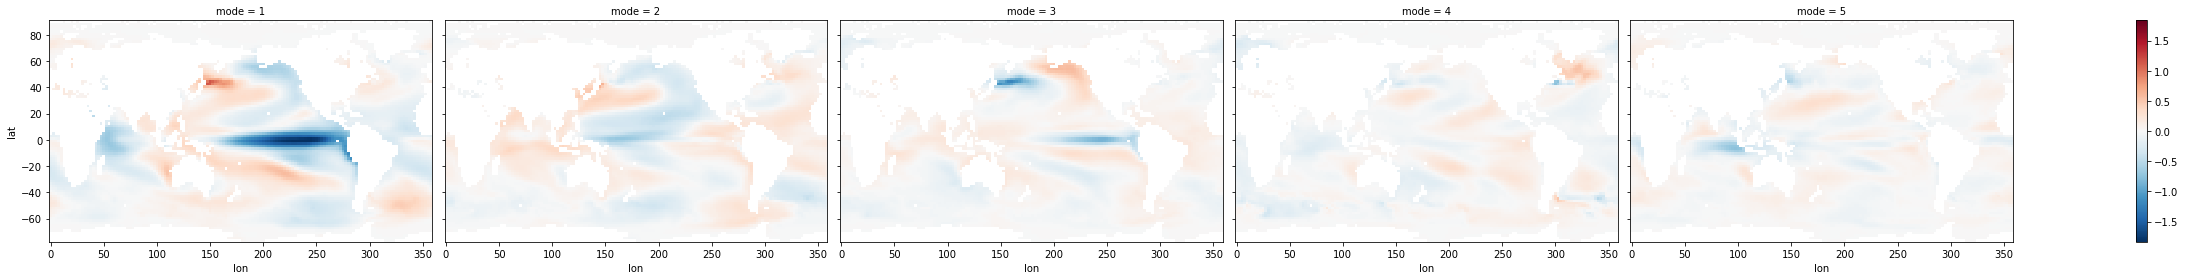

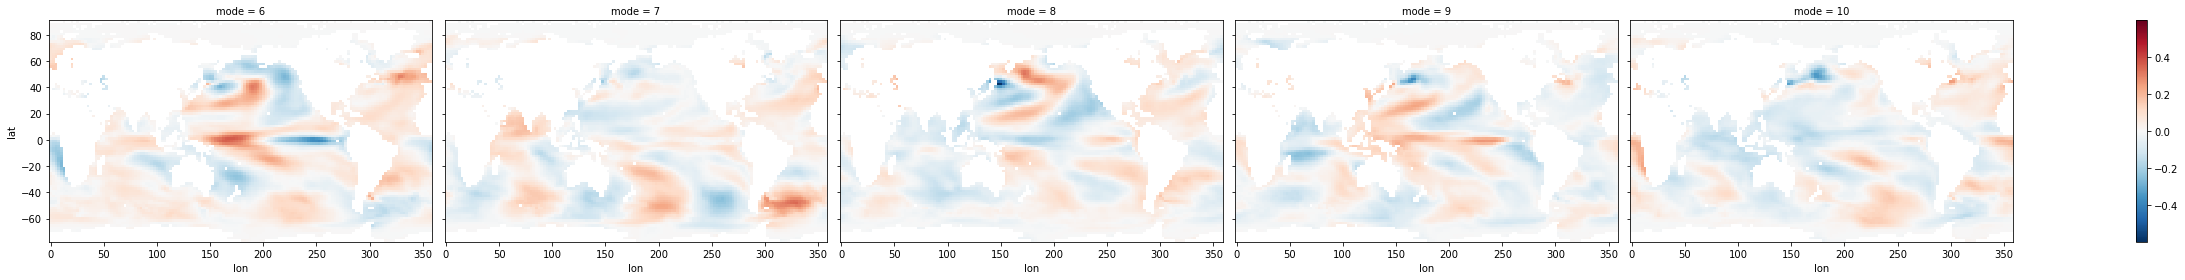

In [96]:
eofs_CESM.sel(mode=slice(1, 5)).plot(col='mode', figsize=(35, 4), rasterized=True);
eofs_CESM.sel(mode=slice(6, 10)).plot(col='mode', figsize=(35, 4), rasterized=True);

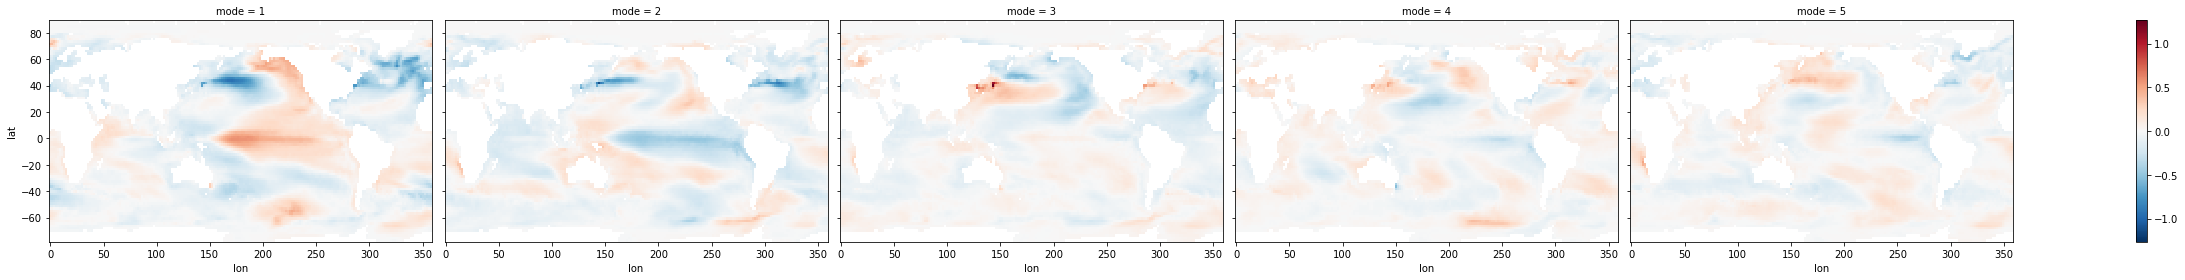

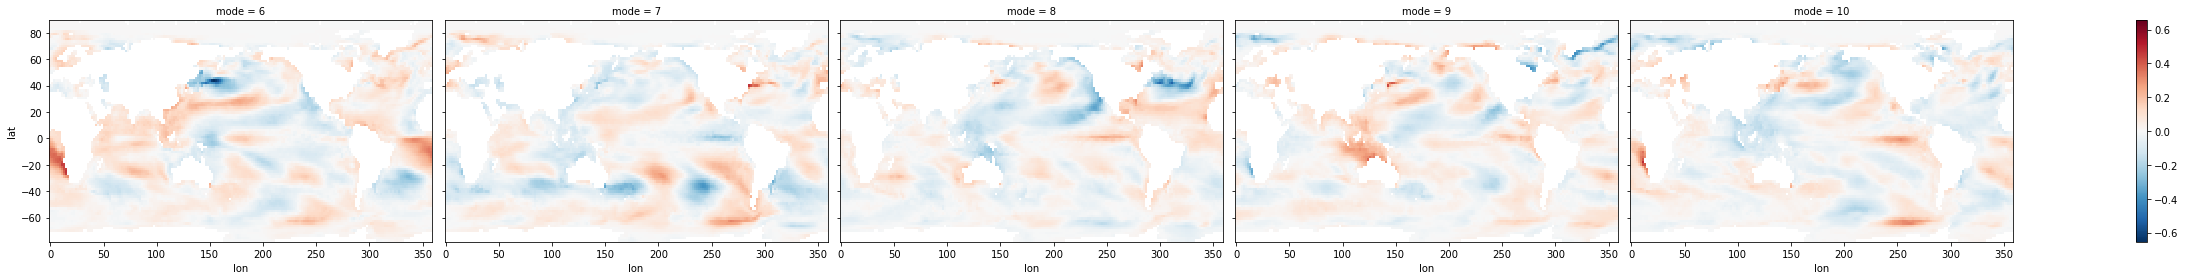

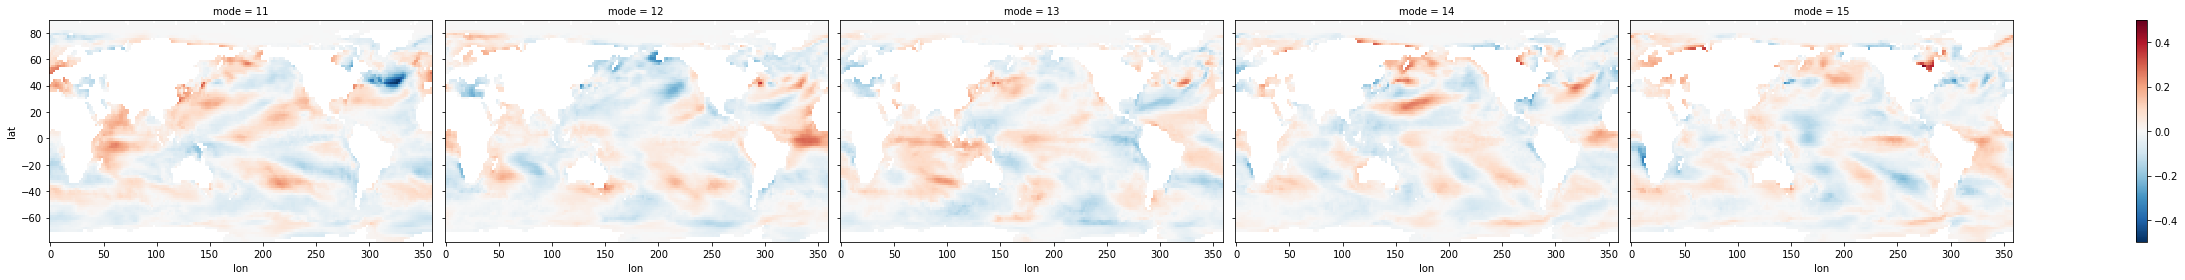

In [97]:
eofs_FOCI.sel(mode=slice(1, 5)).plot(col='mode', figsize=(35, 4), rasterized=True);
eofs_FOCI.sel(mode=slice(6, 10)).plot(col='mode', figsize=(35, 4), rasterized=True);
eofs_FOCI.sel(mode=slice(11, 15)).plot(col='mode', figsize=(35, 4), rasterized=True);

In [16]:
# Get land silhouettes:
land_silhouette_CESM = get_land_silhouette(data_path="GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/", data_source_name="CESM")
land_silhouette_FOCI = get_land_silhouette(data_path="GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/", data_source_name="FOCI")


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [17]:
## Copy first 2 and 3 EOF modes for CESM and FOCI, respectively, and superimpose silhouette, highlighting continents' shape:

# CESM whole world:
eofs_CESM_array = eofs_CESM[:2].values
eofs_silhouette_CESM = np.copy(eofs_CESM_array)
eofs_silhouette_CESM[:,land_silhouette_CESM] = float('nan')

# CESM whole world:
eofs_FOCI_array = eofs_FOCI[:3].values
eofs_silhouette_FOCI = np.copy(eofs_FOCI_array)
eofs_silhouette_FOCI[:,land_silhouette_FOCI] = float('nan')

In [85]:
## Store / reload first 2 EOF modes for slp CESM whole world:

# Set path:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_EOF')



# # Store EOF modes as np.array:
# np.save(path / "eofs_CESM.npy", eofs_CESM_array)

# # Store EOF modes with land silhouette as np.array:
# np.save(path / "eofs_silhouette_CESM.npy", eofs_silhouette_CESM)



# # Reload EOF modes as np.array:
# eofs_CESM_array = np.load(path / "eofs_CESM.npy")

# # Reload EOF modes with land silhouette as np.array:
# eofs_silhouette_CESM = np.load(path / "eofs_silhouette_CESM.npy")

In [18]:
## Store / reload first 3 EOF modes for slp FOCI whole world:

# Set path:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_EOF')



# # Store EOF modes as np.array:
# np.save(path / "eofs_FOCI.npy", eofs_FOCI_array)

# # Store EOF modes with land silhouette as np.array:
# np.save(path / "eofs_silhouette_FOCI.npy", eofs_silhouette_FOCI)



# # Reload EOF modes as np.array:
# eofs_FOCI_array = np.load(path / "eofs_FOCI.npy")

# # Reload EOF modes with land silhouette as np.array:
# eofs_silhouette_FOCI = np.load(path / "eofs_silhouette_FOCI.npy")

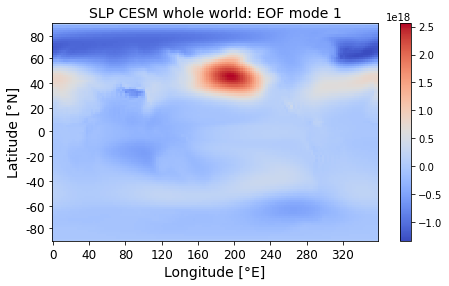

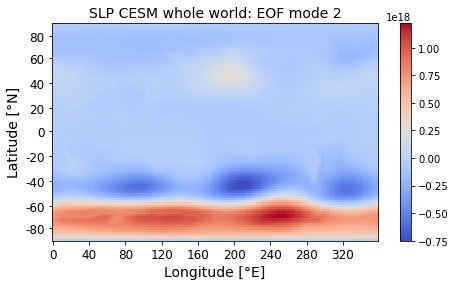

In [90]:
## Plot first 2 EOF modes for CESM as heatmap (without land silhouette):  

# Plot:
for i in range(2):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(np.flip(eofs_CESM_array[i],axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('SLP CESM whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

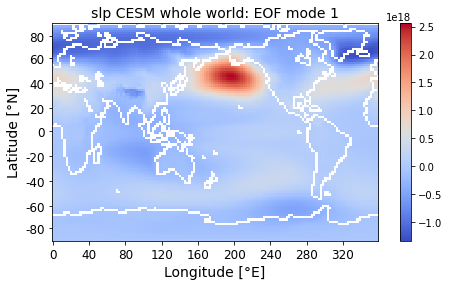

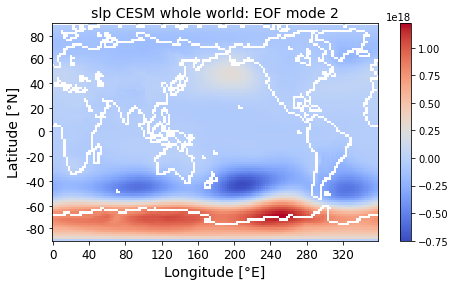

In [91]:
## Plot first 2 EOF modes for CESM as heatmap (with land silhouette):  

# Plot:
for i in range(2):
    
    fig, ax = plt.subplots(figsize=(8,4 ))
    im = plt.imshow(np.flip(eofs_silhouette_CESM[i],axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('slp CESM whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

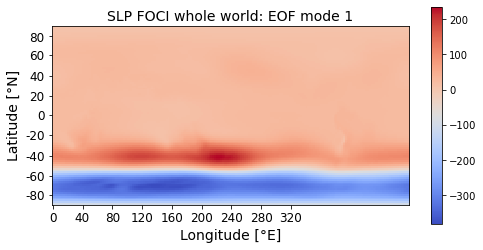

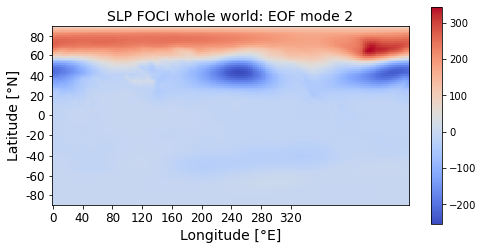

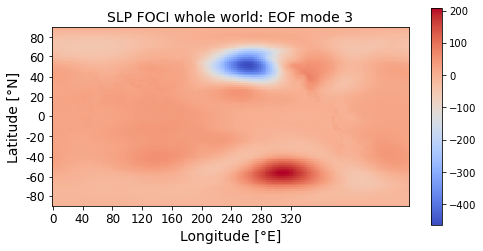

In [21]:
## Plot first 3 EOF modes for FOCI as heatmap (without land silhouette):  

# Plot:
for i in range(3):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(eofs_FOCI_array[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('SLP FOCI whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

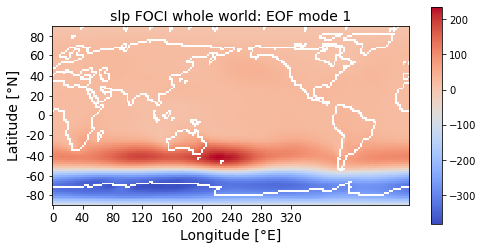

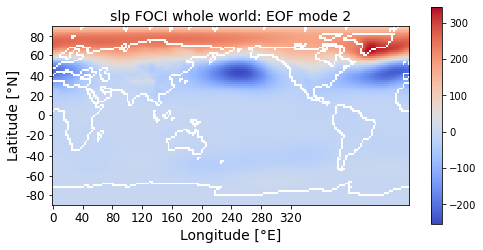

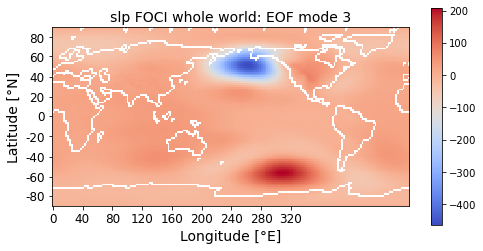

In [22]:
## Plot first 2 EOF modes for FOCI as heatmap (with land silhouette):  

# Plot:
for i in range(3):
    
    fig, ax = plt.subplots(figsize=(8,4 ))
    im = plt.imshow(eofs_silhouette_FOCI[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('slp FOCI whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()